In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import os
from scipy import ndimage
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

2024-02-17 09:18:17.538118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 09:18:17.538252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 09:18:17.803128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_root = '/kaggle/input/bone-age-dataset/'
output_root = '/kaggle/working/'

training_root = 'Bone Age Training Set/Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/Bone Age Validation Set/'
test_root = 'Bone Age Test Set/Bone Age Test Set/'

images_path = 'Images/'
data_path = 'Dataset.csv'
data_test_path = 'Dataset.xlsx'

#We define the paths related to the images
training_images_path = dir_root + training_root + images_path
validation_images_path = dir_root + validation_root + images_path
test_images_path = dir_root + test_root + images_path

#We define the paths related to the dataset
training_data_path = dir_root + training_root + data_path
validation_data_path = dir_root + validation_root + data_path
test_data_path = dir_root + test_root + data_test_path

In [3]:
train = pd.read_csv(training_data_path)
val = pd.read_csv(validation_data_path)
test= pd.read_excel(test_data_path)
#We drop the column related to the gender
train.drop(columns=["male"], inplace=True)
val.drop(columns=["male"], inplace=True)
test.drop(columns=["Sex"], inplace=True)


val.rename(columns={"Image ID": "id"}, inplace=True)
val.rename(columns={"Bone Age (months)": "boneage"}, inplace=True)
test.rename(columns={"Case ID": "id"}, inplace=True)
test.rename(columns={"Ground truth bone age (months)": "boneage"}, inplace=True)

In [4]:
#oldest child in the dataset
print("Max age: " + str(train["boneage"].max()) + " months")

#youngest child in the dataset
print("Min age: " + str(train["boneage"].min()) + " months")

#mean age is
mean_bone_age = train["boneage"].mean()
print("mean: " + str(mean_bone_age))

#median bone age
print("median: " +str(train["boneage"].median()))

#standard deviation of boneage
std_bone_age = train["boneage"].std()

Max age: 228 months
Min age: 1 months
mean: 127.3207517246848
median: 132.0


Text(0.5, 1.0, 'Distribution of the children for the age')

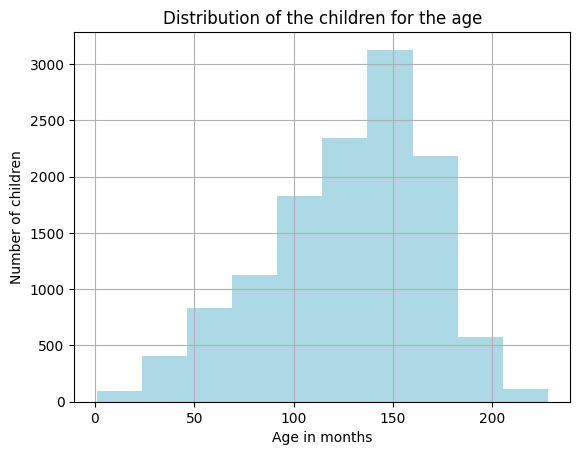

In [5]:
train["boneage"].hist(color = "lightblue")
plt.xlabel("Age in months")
plt.ylabel("Number of children")
plt.title("Distribution of the children for the age")

In [6]:
def generate_path(row):
    return training_images_path + str(row['id']) + '.png'

train['path'] = train.apply(generate_path, axis=1)

(2920, 2320, 3)


Text(0.5, 1.0, 'y = 180')

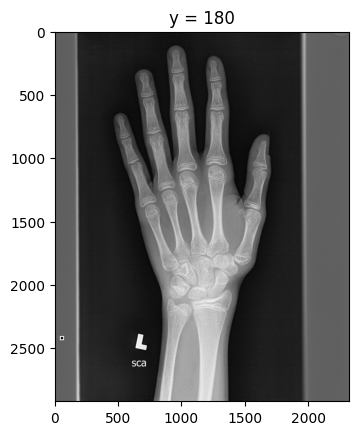

In [7]:
index =1263

image_path = train.loc[:,"path"][index]
#We upload and read the image
img = cv2.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.title("y = " +str(np.squeeze(train.iloc[index, 1])))

In [8]:
def generate_path(row):
    return validation_images_path + str(row['id']) + '.png'

val['path'] = val.apply(generate_path, axis=1)

In [9]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

In [10]:
def apply_clahe(image, cliplimit=4.0, tilegridsize=(8,8)):
    image = image.astype("uint8")
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tilegridsize)
    clahe_image = clahe.apply(image[:,:,0]) 
    
    return np.expand_dims(clahe_image, axis=-1)

In [11]:
image_augmentator_train=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=apply_clahe
)

In [12]:
image_augmentator_test=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=apply_clahe
)

In [13]:
batch_size = 40

train_dataset = image_augmentator_train.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),                             
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='other',
    rescale=1/255)                                     

val_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=val,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 0 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 200 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [14]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

In [15]:
test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 200 validated image filenames.


In [16]:
train_steps = int(np.ceil(len(train)/batch_size))
val_steps = int(np.ceil(len(val)/batch_size))
test_steps = int(np.ceil(len(test)/batch_size))

In [17]:
def identity_block(X, f, filters):
        
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

In [18]:
def convolutional_block(X, f, filters, s):
        
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

In [19]:
def ResNet50(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D(pool_size=(2, 2))(X)
    X = Flatten()(X)
    X = Dense(1, activation='linear', name='fc')(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [20]:
model_2 = ResNet50((256, 256, 1))

# Compile the model
model_2.compile(optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [21]:
model_2.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         3200      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']       

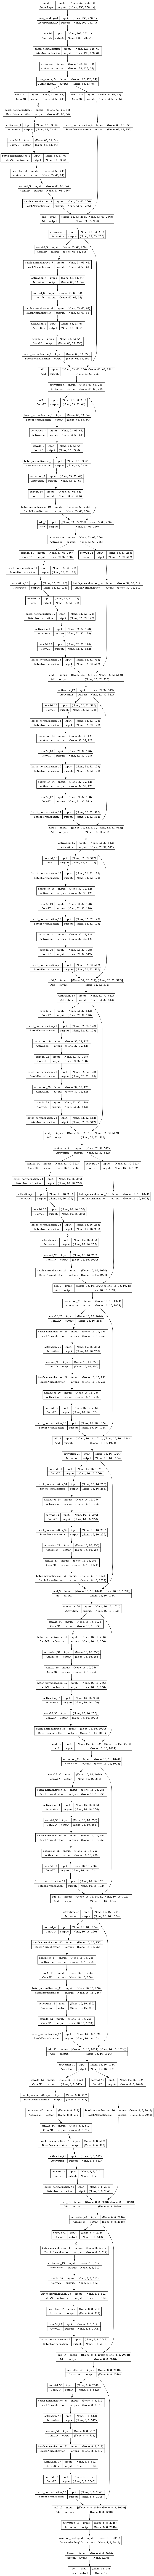

In [22]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=16, restore_best_weights=True)

In [24]:
model_2_history = model_2.fit(train_dataset, epochs=70, callbacks=callback, steps_per_epoch=train_steps,  validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/70


I0000 00:00:1708161585.920675      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 [==============================] - 709s 2s/step - loss: 1273.3224 - mean_absolute_error: 27.7445 - val_loss: 4662.7993 - val_mean_absolute_error: 59.7235
Epoch 2/70
316/316 [==============================] - 462s 1s/step - loss: 828.8859 - mean_absolute_error: 22.4110 - val_loss: 20431.5117 - val_mean_absolute_error: 134.1070
Epoch 3/70
316/316 [==============================] - 463s 1s/step - loss: 733.1166 - mean_absolute_error: 21.0803 - val_loss: 3074.3035 - val_mean_absolute_error: 48.7250
Epoch 4/70
316/316 [==============================] - 461s 1s/step - loss: 634.5286 - mean_absolute_error: 19.7105 - val_loss: 2739.2266 - val_mean_absolute_error: 44.6194
Epoch 5/70
316/316 [==============================] - 457s 1s/step - loss: 630.8073 - mean_absolute_error: 19.5241 - val_loss: 3675.6277 - val_mean_absolute_error: 52.3556
Epoch 6/70
316/316 [==============================] - 457s 1s/step - loss: 557.9902 - mean_absolute_error: 18.5219 - val_loss: 1406.9812 - val_mean_

In [25]:
model_2.save('ResNet50.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
def plot_loss(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model Loss - MSE")
    plt.ylabel("loss - MSE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

In [27]:
def plot_MAE(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model MAE")
    plt.ylabel("MAE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

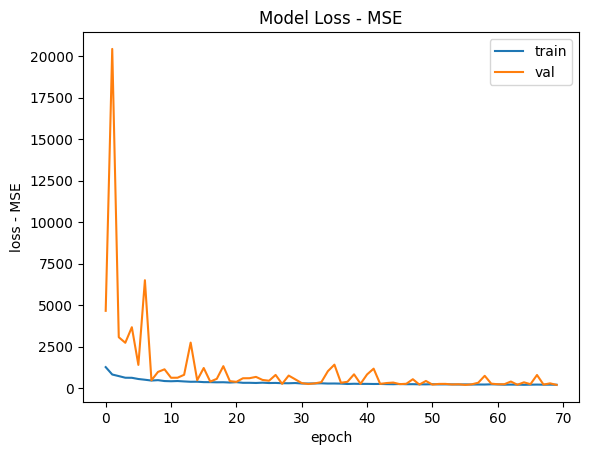

In [28]:
plot_loss(model_2_history, "loss")

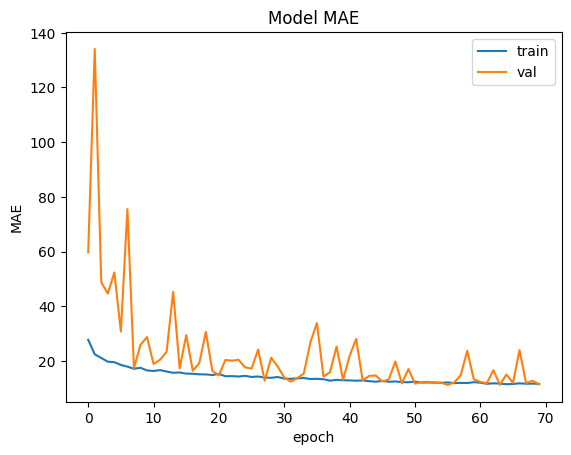

In [29]:
plot_MAE(model_2_history, "mean_absolute_error")

In [30]:
model_2_evaluation = model_2.evaluate(test_dataset, verbose="auto", steps=test_steps)
print("MSE on the Test = " + str(model_2_evaluation[0]))
print("MAE on the Test = " + str(model_2_evaluation[1]))

5/5 [==============================] - 9s 2s/step - loss: 219.5259 - mean_absolute_error: 11.9440
MSE on the Test = 219.52586364746094
MAE on the Test = 11.944035530090332


In [31]:
test_x, test_y = next(test_dataset)
model_2.load_weights('ResNet50.h5')
prediction = (model_2.predict(test_x, batch_size = 40, verbose = True))
test_months = (test_y)


for i in random.sample(range(len(test_x)), 4):
    print("image number: " + str(i))
    print("Age: " + str(test_months[i]))
    print(" Predicted Age: " + str(prediction[i]))

1/1 [==============================] - 1s 1s/step
image number: 20
Age: 166.45243362118603
 Predicted Age: [148.72154]
image number: 28
Age: 24.5254937011514
 Predicted Age: [35.794353]
image number: 11
Age: 120.72840285367793
 Predicted Age: [95.55647]
image number: 32
Age: 150.38506742060892
 Predicted Age: [140.32262]
